In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('/kaggle/input/machine-failure-prediction-iti-data-science/train.csv')

In [3]:
df.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

In [5]:
df['Machine failure'].value_counts()

Machine failure
0    134281
1      2148
Name: count, dtype: int64

In [6]:
train_df=df.drop(columns=['Machine failure','TWF','HDF','PWF','OSF','RNF','Type'],axis=0)

In [7]:
train_df.head()

,id,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0,L50096,300.6,309.6,1596,36.1,140
1,1,M20343,302.6,312.1,1759,29.1,200
2,2,L49454,299.3,308.5,1805,26.5,25
3,3,L53355,301.0,310.9,1524,44.3,197
4,4,M24050,298.0,309.0,1641,35.4,34


In [8]:
train_df.isnull().sum()

id                         0
Product ID                 0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
dtype: int64

In this dataset, I don't check for outliers as if we want to do that we will include numerical columns such as Rotational speed and Torque but that might be necessary for detecting failures.

With looking at the dataset and reading discussions about it I found that including Power as another column would be a good idea to analyse the performance of the machine. Formula for power using given params -> Torque * 2 * pi * rotational speed / 60

In [9]:
train_df['Power'] = train_df['Torque [Nm]'] * 2 * np.pi * train_df['Rotational speed [rpm]'] / 60

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Air temperature [K]      136429 non-null  float64
 3   Process temperature [K]  136429 non-null  float64
 4   Rotational speed [rpm]   136429 non-null  int64  
 5   Torque [Nm]              136429 non-null  float64
 6   Tool wear [min]          136429 non-null  int64  
 7   Power                    136429 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 8.3+ MB


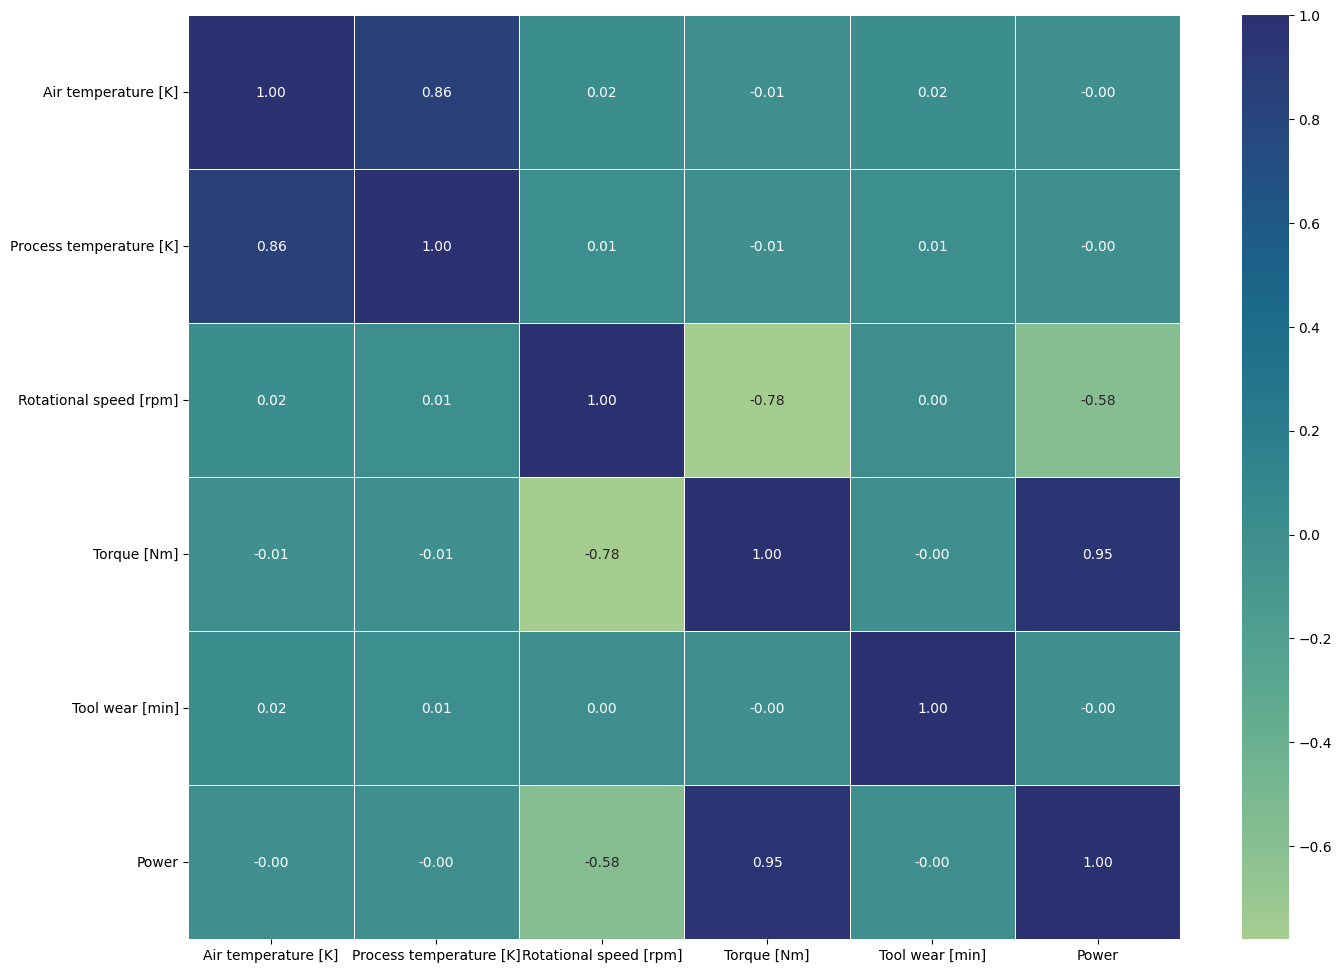

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_cols = ['Air temperature [K]',
'Process temperature [K]',
'Rotational speed [rpm]',
'Torque [Nm]',
'Tool wear [min]', 'Power']

corr_matrix = train_df[corr_cols].corr()

_, ax = plt.subplots(1,1, figsize=(16, 12))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', linewidth = 0.5, cmap = 'crest', ax = ax)
plt.show()

Outtakes:

Air and process temperature exhibits positive linear correlation: this could be expected (machines reach higher temperature in hotter environments), however the similarity in the ranges of air and process temperatures could be indicative of incorrect measurements/ bad sensor placement.
Torque is higly positive correlated with power, as expected by the power formula, and is negatively correlated to the rotational speed.
No other significant LINEAR correlation is detected.

So our data is final now with an additional power feature that we added.


Training

For training we select the features deemed more significant from EDA, that is:

1. Numerical features: Torque, Rotational speed, Power, Tool wear.
2. Categorical features: TWF, HDF, PWF, OSF (I already ignored them to make it simpler and more generalisable for different types of data)

Earlier we observed that the value counts for the machine being a failure is very less as compared to not being a failure so our data is highly unbalanced. For such kind of dataset Boost classifiers are good options such as XGBoost classifier and LightGBM classifier. So I will use GridSearchCV for these 2 and RandomForestClassifier.

We also will use stratified k fold validation to take into account the imbalance

In [12]:
num_feats = ['Tool wear [min]', 'Torque [Nm]', 'Power', 'Rotational speed [rpm]']
cat_feats = ['TWF', 'HDF', 'PWF', 'OSF']
target='Machine failure'
X_train = train_df[num_feats]
y_train = df[target]

In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, auc
import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings

In [14]:

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

preprocessor_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_feats)
])


In [15]:

model_dict = {
    'XGB': XGBClassifier(),
    'RFC': RandomForestClassifier(),
    'LGBM': LGBMClassifier(),
}

params_dict = {
    'XGB': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [8, 10, 12],
        'model__learning_rate': [1e-3, 1e-2, 1e-1],
    },
    'RFC': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [8, 10, 12],
        'model__min_samples_leaf': [1, 3, 5],
    },
    'LGBM': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [8, 10, 12],
        'model__learning_rate': [1e-3, 1e-2, 1e-1],
        'model__num_leaves': [31, 63, 127],
    },
}


In [16]:
from tqdm import tqdm  

grid_results = pd.DataFrame({
    'MODEL': model_dict.keys(),
    'BEST_SCORE': np.zeros(len(model_dict)),
    'BEST_PARAMS': np.zeros(len(model_dict), dtype=object),
    'TIME': np.zeros(len(model_dict)),
})

i = 0
best_model_params = model_dict.copy()

for key, model in tqdm(model_dict.items(), desc="Training Models"):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=ConvergenceWarning)

        print(f"\nTraining model: {key}")

        full_pipeline = Pipeline([
            ('preprocessor', preprocessor_pipeline), 
            ('model', model),
        ])

        start = time.time()
        cross_validation = StratifiedKFold(n_splits=5, shuffle=True)
        model_gscv = GridSearchCV(
            full_pipeline,
            param_grid=params_dict[key],
            cv=cross_validation,
            scoring='roc_auc',
            n_jobs=-1,
        )
        model_gscv.fit(X_train, y_train)  
        stop = time.time()

        # Store results
        grid_results.iloc[i, 1] = model_gscv.best_score_
        grid_results.iloc[i, 2] = str(model_gscv.best_params_)
        grid_results.iloc[i, 3] = np.round(stop - start, 2)

        best_model_params[key] = model_gscv.best_params_

        print(f"Model: {key}")
        print(f"Best Score: {model_gscv.best_score_}")
        print(f"Best Parameters: {model_gscv.best_params_}")
        print(f"Training Time (s): {grid_results.iloc[i, 3]}")

        i += 1

print("\nGrid Search Results:")
print(grid_results)


Training Models:   0%|          | 0/3 [00:00<?, ?it/s]


Training model: XGB


Training Models:  33%|███▎      | 1/3 [00:42<01:24, 42.28s/it]

Model: XGB
Best Score: 0.9122125644715817
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 100}
Training Time (s): 42.28

Training model: RFC


Training Models:  67%|██████▋   | 2/3 [16:40<09:41, 581.31s/it]

Model: RFC
Best Score: 0.9126866511184399
Best Parameters: {'model__max_depth': 12, 'model__min_samples_leaf': 3, 'model__n_estimators': 200}
Training Time (s): 958.62

Training model: LGBM
[LightGBM] [Info] Number of positive: 2148, number of negative: 134281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1011
[LightGBM] [Info] Number of data points in the train set: 136429, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015744 -> initscore=-4.135397
[LightGBM] [Info] Start training from score -4.135397


Training Models: 100%|██████████| 3/3 [25:42<00:00, 514.14s/it]

Model: LGBM
Best Score: 0.9151606541713463
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__num_leaves': 31}
Training Time (s): 541.52

Grid Search Results:
  MODEL  BEST_SCORE                                        BEST_PARAMS    TIME
0   XGB    0.912213  {'model__learning_rate': 0.1, 'model__max_dept...   42.28
1   RFC    0.912687  {'model__max_depth': 12, 'model__min_samples_l...  958.62
2  LGBM    0.915161  {'model__learning_rate': 0.1, 'model__max_dept...  541.52


So we achieve maximum accuracy on LightGBM Classifier with paramters learning_rate= 0.1,max_depth=10,n_estimators=100,num_leaves=31
and thus will use this as our final pipeline.

In [25]:
best_estimator = LGBMClassifier(learning_rate= 0.1,max_depth=10,n_estimators=100,num_leaves=31)
best_pipeline = Pipeline([
    ('preprocessor', preprocessor_pipeline),
    ('model', best_estimator)
])

best_pipeline.fit(X_train, y_train)

c:\Users\rishi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2148, number of negative: 134281
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1011
[LightGBM] [Info] Number of data points in the train set: 136429, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.015744 -> initscore=-4.135397
[LightGBM] [Info] Start training from score -4.135397


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Tool wear [min]',
                                                   'Torque [Nm]', 'Power',
                                                   'Rotational speed '
                                                   '[rpm]'])])),
                ('model', LGBMClassifier(max_depth=10))])

In [27]:
from joblib import dump

# Assume `pipeline` is your machine learning pipeline
dump(best_pipeline, 'best_pipeline.joblib')


['best_pipeline.joblib']